# Classifying Blood Smears with a Convolutional Neural Network

This notebook provides you with a complete code example that loads the malaria dataset, trains a convolutional neural network with dense top to classify the images of cell with and without malaria, analyzes where the trained network fails, and shows the network activations and heatmaps.

## Loading the Malaria Dataset

This dataset was originally published in S. Rajaraman, S. K. Antani, M. Poost- chi, K. Silamut, Md A. Hossain, R. J. Maude, S. Jaeger, and G. R. Thoma. _Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images._ PeerJ 6, e4568, 2018.

It is available at https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip.


In [1]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "blood_smears_dataset")
if not os.path.exists(dataset_path):
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    download_url(url, ".")
    _extract_zip("cell_images.zip", dataset_path, None)
    os.remove("cell_images.zip")

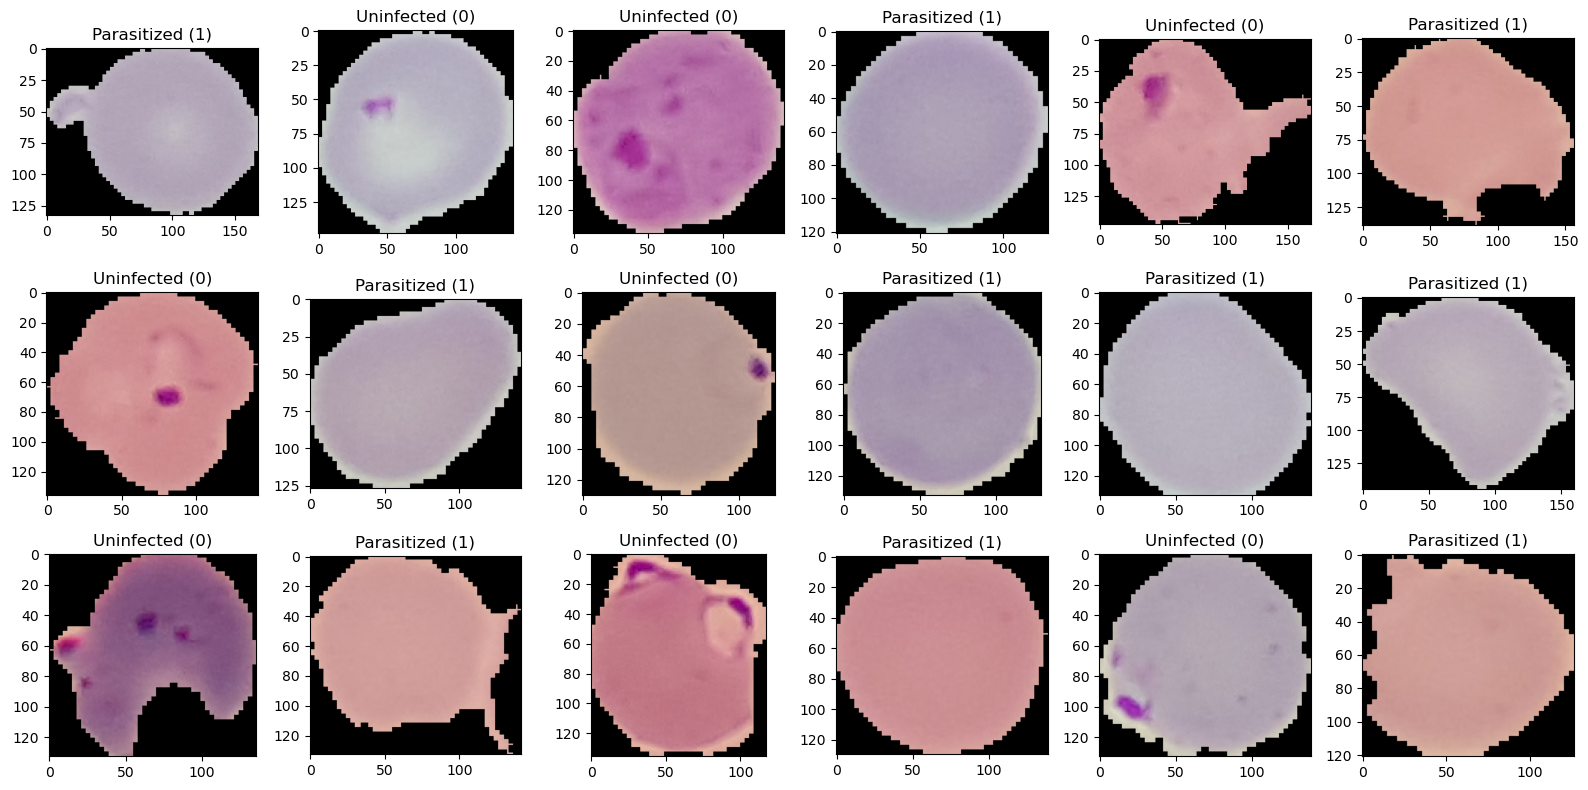

In [ ]:
###
from torchvision.datasets import ImageFolder

base_dir = os.path.join(dataset_path, "cell_images") 
dataset = ImageFolder(base_dir)

import matplotlib.pyplot as plt
import numpy as np

def plot_blood_smears(dataset, parasitized):
    """Plot blood smears."""
    fig, axs = plt.subplots(3, 6, figsize=(16, 8))
    for ax in axs.ravel():
        image, label = dataset[np.random.randint(0, len(dataset))]
        ax.imshow(image)
        ax.set_title(f"Uninfected ({label})" if label == parasitized
                     else f"Parasitized ({label})")
    plt.tight_layout()
    plt.savefig("fig_03_A1.pdf", bbox_inches='tight')  ### plt.show()

plot_blood_smears(dataset, parasitized=0)

### Transforming the Images and Their Ground Thruth

Define a transformation to resize the images to 28 by 28 pixels and convert them to PyTorch tensors (note that `ToTensor()` also normalizes their values between 0 and 1) ...

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor 

image_transform = Compose([Resize((28, 28)), ToTensor()])

... define a transformation to make the target label equal to 0 for the uninfected cells and to 1 for the parasitized ones, converting it into a floating-point PyTorch tensor and adding a new dimension for batch processing ...

In [ ]:
import torch

def label_transform(label):
    """Transform label."""
    return torch.tensor(1 - label).float().unsqueeze(-1)

... and define a dataset that also makes these transformations.

In [ ]:
from torchvision.datasets import ImageFolder

base_dir = os.path.join(dataset_path, "cell_images")
dataset = ImageFolder(base_dir,
                      transform=image_transform,
                      target_transform=label_transform)

### Visualizing the Blood Smears

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_blood_smears(dataset, parasitized, fig_name):  ### def plot_blood_smears(dataset, parasitized):
    """Plot blood smears."""
    fig, axs = plt.subplots(3, 6, figsize=(16, 8))
    for ax in axs.ravel():
        image, label = dataset[np.random.randint(0, len(dataset))]
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose(1, 2, 0)
        ax.imshow(image)
        ax.set_title(f"Parasitized ({label})" if label == parasitized
                     else f"Uninfected ({label})")
    plt.tight_layout()
    plt.savefig(fig_name, bbox_inches='tight')  ### plt.show()

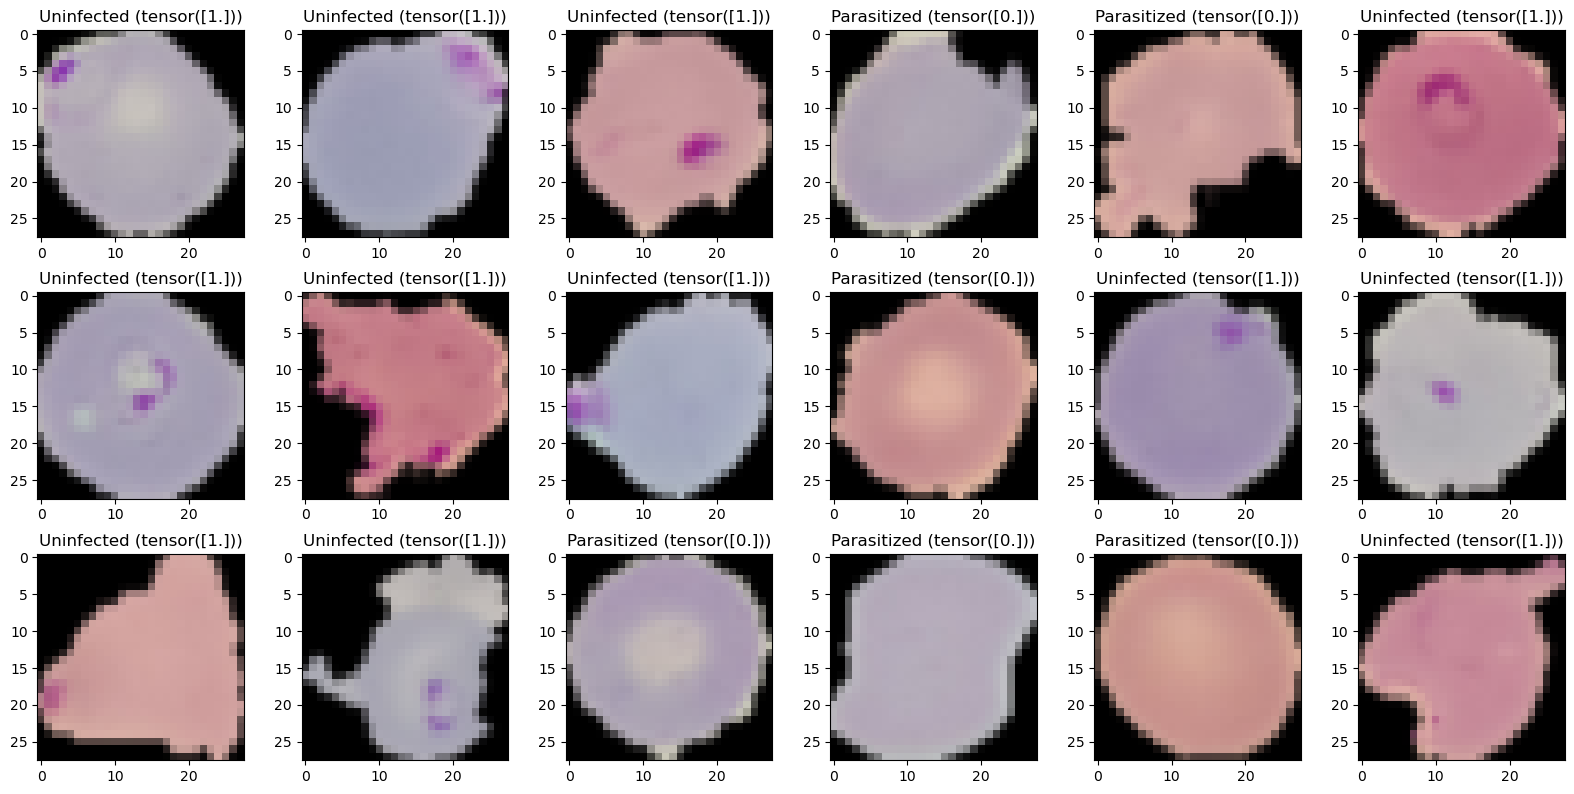

In [ ]:
plot_blood_smears(dataset, parasitized=1, fig_name="fig_03_A2.pdf")  ### plot_blood_smears(dataset, parasitized=1)

### Splitting the Dataset and Defining the Data Loaders

Split the dataset, composed by ca. 27,000 cell images, into train (80%) and test (20%) sets.

In [ ]:
from torch.utils.data import DataLoader, random_split

train, test = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)

## Classifying the Blood Smears with Dense Neural Networks

Implement a dense neural network ...

In [ ]:
import deeplay as dl
from torch.nn import Sigmoid

dnn = dl.MultiLayerPerceptron(
    in_features=28 * 28 * 3, 
    hidden_features=[128, 128], 
    out_features=1,
    out_activation=Sigmoid, 
)

print(dnn)

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LayerActivationNormalizationDropout(
      (layer): Layer[Linear](in_features=2352, out_features=128)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=128)
      (dropout): Layer[Dropout](p=0)
    )
    (1): LayerActivationNormalizationDropout(
      (layer): Layer[Linear](in_features=128, out_features=128)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=128)
      (dropout): Layer[Dropout](p=0)
    )
    (2): LayerActivationNormalizationDropout(
      (layer): Layer[Linear](in_features=128, out_features=1)
      (activation): Layer[Sigmoid]()
      (normalization): Layer[Identity](num_features=1)
      (dropout): Layer[Dropout](p=0)
    )
  )
)


... and compile it.

In [ ]:
dnn_classifier_template = dl.BinaryClassifier(model=dnn,
                                              optimizer=dl.RMSprop(lr=0.001))
dnn_classifier = dnn_classifier_template.create()

print(dnn_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LayerActivationNormalizationDropout(
        (layer): Linear(in_features=2352, out_features=128, bias=True)
        (activation): ReLU()
        (normalization): Identity()
        (dropout): Dropout(p=0, inplace=False)
      )
      (1): LayerActivationNormalizationDropout(
        (layer): Linear(in_features=128, out_features=128, bias=True)
        (activation): ReLU()
        (normalization): Identity()
        (dropout): Dropout(p=0, inplace=False)
      )
      (2): LayerActivationNormalizationDropout(
        (layer): Linear(in_features=128, out_features=1, bias=True)
        (activation): S

The default loss of `dl.BinaryClassifier` is a binary cross-entropy loss.

### Training the Dense Neural Network

In [ ]:
dnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
dnn_trainer.fit(dnn_classifier, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-03-15 05:23:58.056120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name          | Type                 | Params
-------------------------------------------------------
0 | loss          | BCELoss              | 0     
1 | train_metrics | MetricCollection     | 0     
2 | val_metrics   | MetricCollection     | 0     
3 | test_metrics  | MetricCollection     | 0     
4 | 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


### Testing the Dense Neural Network

In [ ]:
dnn_trainer.test(dnn_classifier, test_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testBinaryAccuracy_epoch    0.6612229943275452
     test_loss_epoch        0.6070444583892822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.6070444583892822,
  'testBinaryAccuracy_epoch': 0.6612229943275452}]

### Plotting the ROC Curve

In [ ]:
import torchmetrics as tm

def plot_roc(classifier, loader, fig_name): ### def plot_roc(classifier, loader):
    """Plot ROC curve."""
    roc = tm.ROC(task="binary")
    
    for image, label in loader: 
        roc.update(classifier(image), label.long())
    
    fig, ax = roc.plot(score=True) 
    ax.grid(False) 
    ax.axis("square") 
    ax.set_xlim(0, 1) 
    ax.set_ylim(0, 1) 
    ax.legend(loc="center right")
    plt.savefig(fig_name, bbox_inches='tight')  ### plt.show()

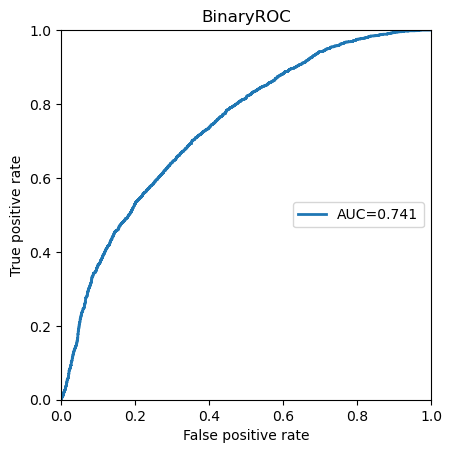

In [ ]:
plot_roc(dnn_classifier, test_loader, fig_name="fig_03_A3.pdf")  ### plot_roc(dnn_classifier, test_loader)

## Classifying the Blood Smears with Convolutional Neural Networks

Implement a convolutional neural network with a dense top ...

In [ ]:
from torch.nn import AdaptiveAvgPool2d, MaxPool2d

conv_base = dl.ConvolutionalNeuralNetwork(
    in_channels=3, 
    hidden_channels=[16, 16, 32],
    out_channels=32,
)
conv_base.blocks[2].pool.configure(MaxPool2d, kernel_size=2)
connector = dl.Layer(AdaptiveAvgPool2d, output_size=1)

dense_top = dl.MultiLayerPerceptron(
    in_features=32, hidden_features=[],
    out_features=1,
    out_activation=Sigmoid,
)

cnn = dl.Sequential(conv_base, connector, dense_top)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (3): PoolLayerActivationNormalization(
        (pool): Layer[Ident

... and compile it.

In [ ]:
cnn_classifier_template = dl.BinaryClassifier(model=cnn,
                                              optimizer=dl.RMSprop(lr=0.001))
cnn_classifier = cnn_classifier_template.create()

print(cnn_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (1): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (2): PoolLayerActivationNormalization(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=

### Training the Convolutional Neural Network

In [ ]:
cnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
cnn_trainer.fit(cnn_classifier, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | BCELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 16.7 K
5 | optimizer     | RMSprop          | 0     
---------------------------------------------------
16.7 K    Trainable params
0         Non-trainable params
16.7 K    Total params
0.067     Total estimated model params size (MB)
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pyto

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


### Testing the Convolutional Neural Network

In [ ]:
cnn_trainer.test(cnn_classifier, test_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testBinaryAccuracy_epoch    0.9473779797554016
     test_loss_epoch        0.15683798491954803
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.15683798491954803,
  'testBinaryAccuracy_epoch': 0.9473779797554016}]

### Plotting the ROC Curve

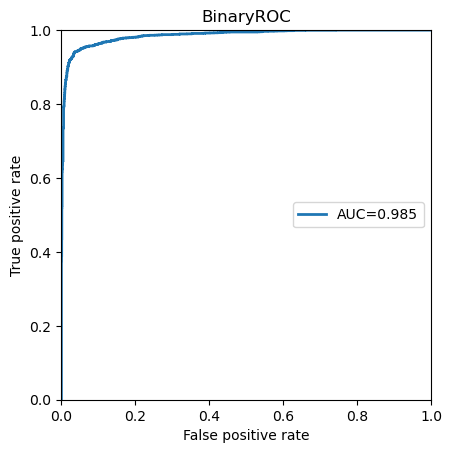

In [ ]:
plot_roc(cnn_classifier, test_loader, fig_name="fig_03_A4.pdf")  ### plot_roc(cnn_classifier, test_loader)

### Performing a Failure Analysis

In [ ]:
def plot_failures(images, labels, pred, threshold=0.5, plot_num=5, fig_name=""):  ### def plot_failures(images, labels, pred, threshold=0.5, plot_num=5):
    """Plot incorrectly classified blood smears."""
    pred = np.array(pred).squeeze()
    labels = np.array(labels).squeeze()
    images = np.array(images)
    
    false_positives = (pred > threshold) & (labels == 0)
    false_positives_images = images[false_positives]
    
    false_negatives = (pred < threshold) & (labels == 1)
    false_negatives_images = images[false_negatives]
    
    plt.figure(figsize=(plot_num * 2, 5))
    for i in range(plot_num):
        # False positives.
        plt.subplot(2, plot_num, i + 1) 
        plt.imshow(false_positives_images[i].transpose(1, 2, 0)) 
        if i == 0:
            plt.title("False positives", fontsize=16, y=1.1)

        # False negatives.
        plt.subplot(2, plot_num, plot_num + i + 1) 
        plt.imshow(false_negatives_images[i].transpose(1, 2, 0)) 
        if i == 0:
            plt.title("False negatives", fontsize=16, y=1.1)
    
    plt.tight_layout()
    plt.savefig(fig_name, bbox_inches='tight')  ### plt.show()

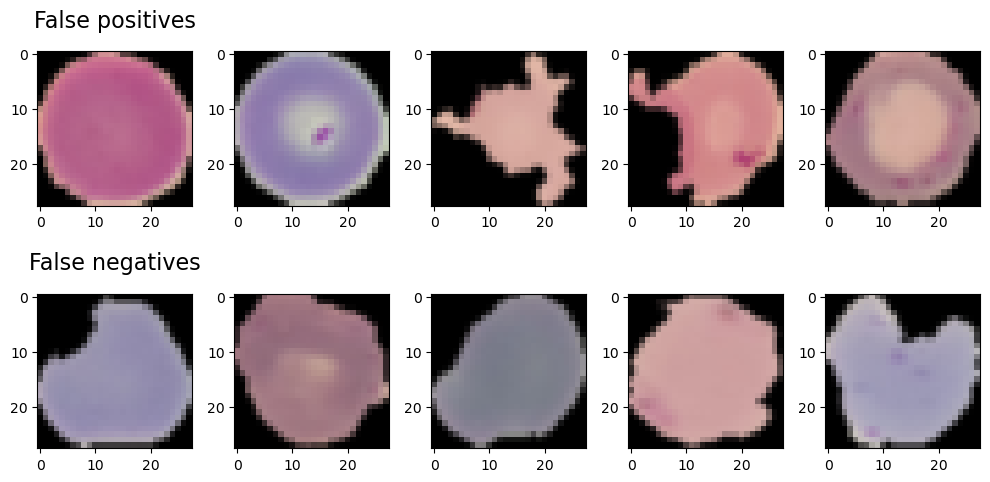

In [ ]:
images, labels = zip(*test)
pred = cnn_classifier(torch.stack(images)).tolist()
plot_failures(images, labels, pred, fig_name="fig_03_A5.pdf")  ## plot_failures(images, labels, pred)

### Checking the Values of the Filters

The following code accesses the 32nd filter's weights in the first convolutional layer of the CNN. It navigates through the model's first module (`model[0]`), selects the initial block (`blocks[0]`), and then targets the layer's weights (`layer.weight[15]`). 

In [ ]:
filter = cnn_classifier.model[0].blocks[0].layer.weight[15]
print(filter)

tensor([[[ 0.0464,  0.2012, -0.0435],
         [ 0.0237,  0.2049, -0.0695],
         [ 0.0031, -0.0737,  0.0478]],

        [[ 0.1521,  0.2301,  0.3442],
         [-0.1067, -0.3801, -0.2747],
         [-0.2086, -0.2725, -0.3367]],

        [[ 0.1481, -0.1201,  0.1746],
         [-0.0346,  0.0147,  0.2548],
         [ 0.1626, -0.0248,  0.0869]]], grad_fn=<SelectBackward0>)


### Visualizing the Activations of the Convolutional Layers

Pick the image of an infected smear to then check the activations it produces on the last convolutional layer ...

In [ ]:
from PIL import Image

im_ind = 0

image_hr = Image.open(dataset.samples[im_ind][0])
image = image_transform(image_hr)

label = label_transform(dataset.targets[im_ind])
print(label)  # Check that it corresponds to a Parasitized image (label == 1).

tensor([1.])


... define a function to visualize the activations ...

In [ ]:
counter = {}  ###
counter["current"] = 5

def plot_activations(activations, cols=8):
    """Visualize activations."""
    rows = -(activations.shape[0] // -cols)

    counter["current"] += 1
    print(counter)  ###
    
    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis("off")
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i, fontsize=16)
    fig.tight_layout()
    plt.savefig(f"fig_03_A{counter['current']}.pdf", bbox_inches='tight')  ### plt.show()

... add a hook to access the activations in the forward pass ...


{'current': 6}
{'current': 7}
{'current': 8}
{'current': 9}


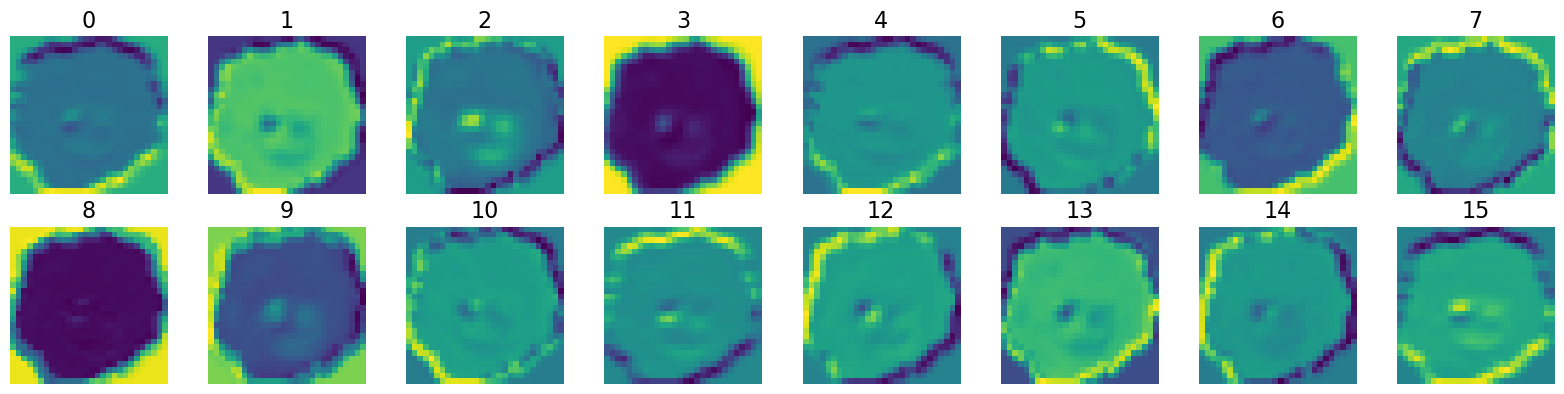

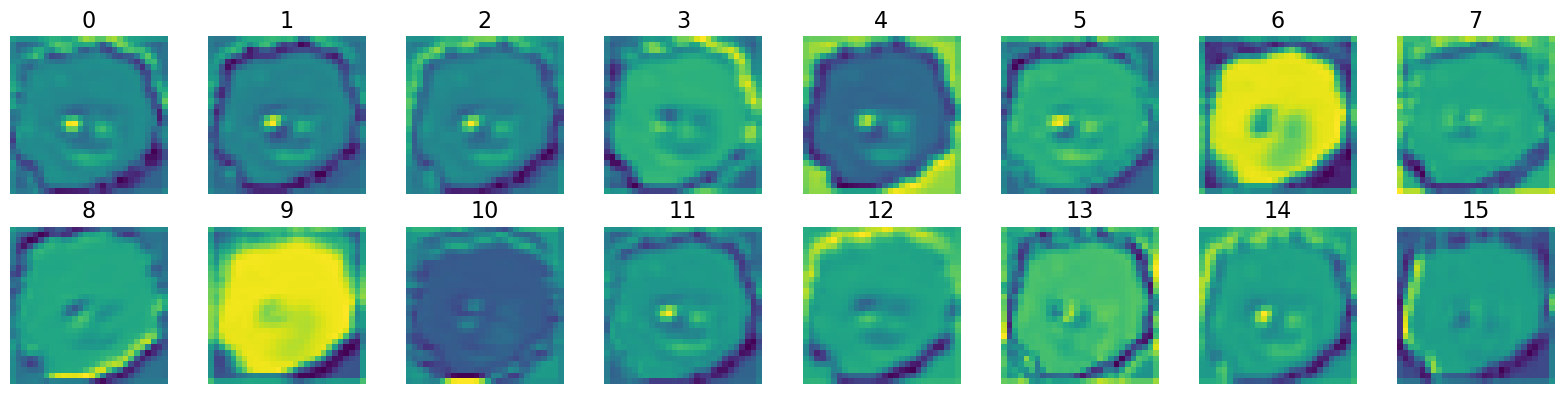

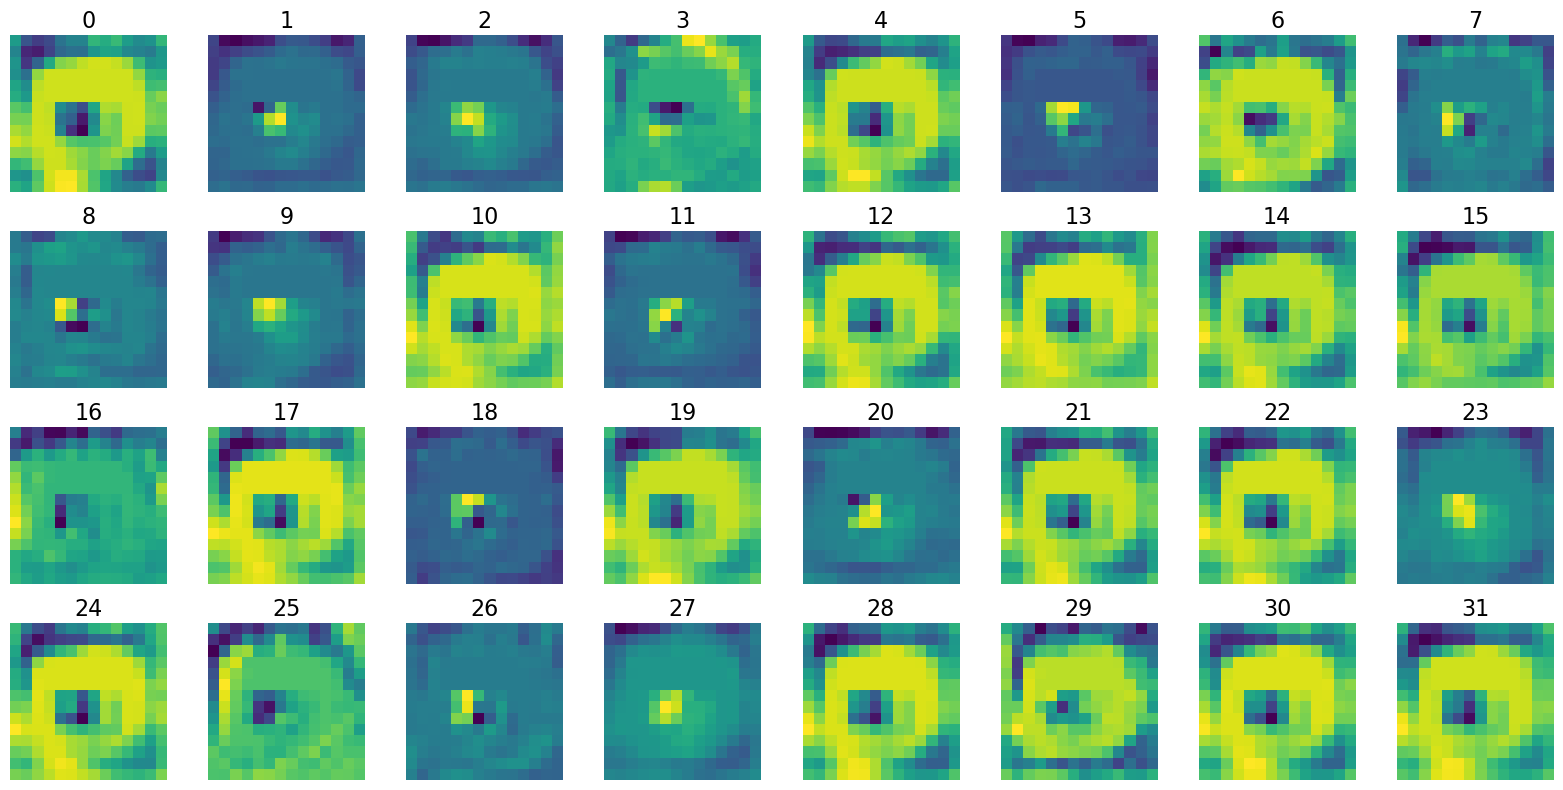

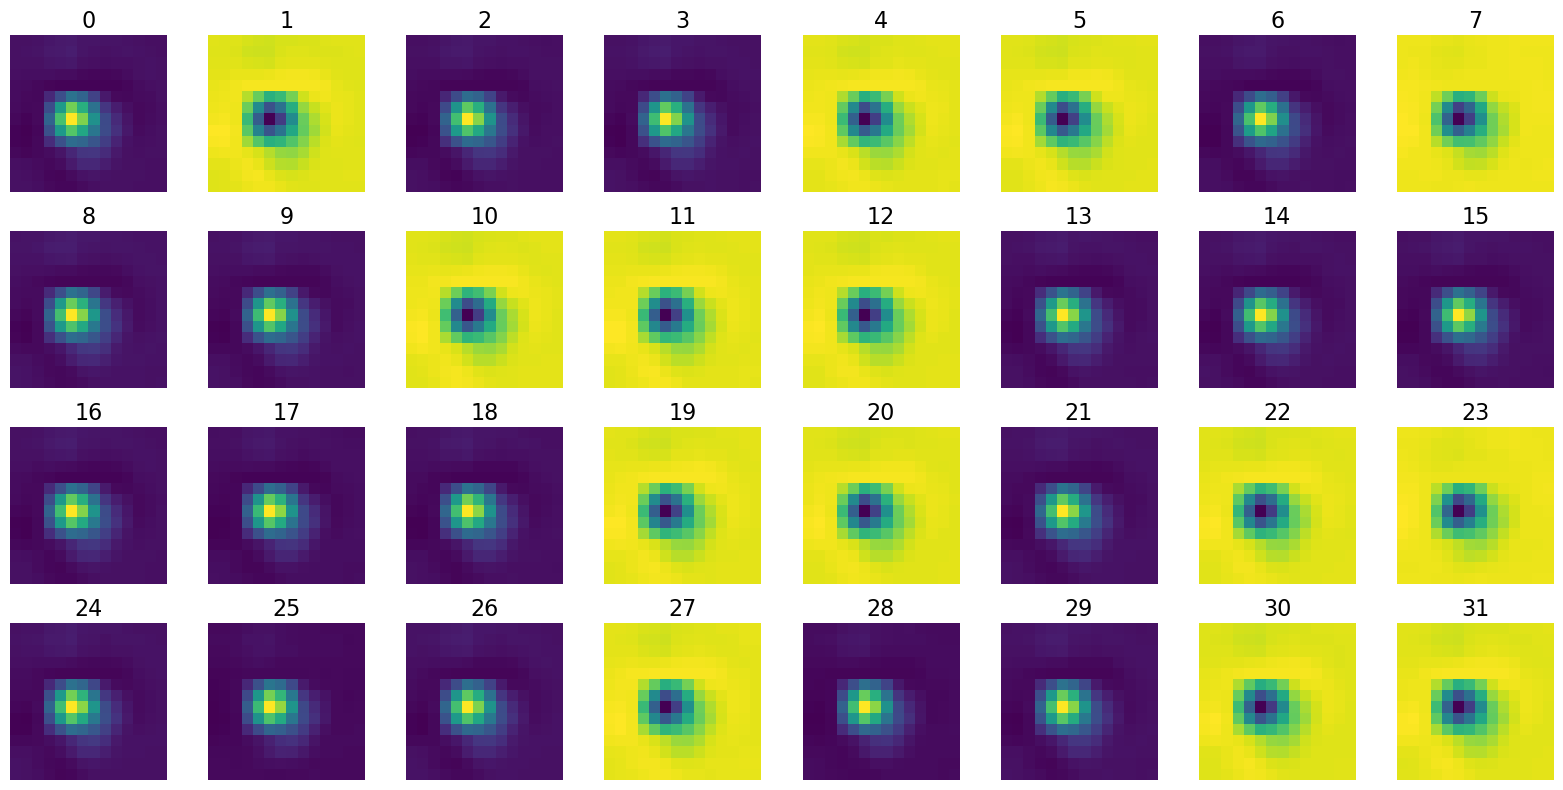

In [ ]:
def hook_func(layer, input, output):
    """Hook for activations."""
    activations = output.detach().clone()
    plot_activations(activations[0])

for block in cnn_classifier.model[0].blocks: 
    layer = block.layer
    handle_hook = layer.register_forward_hook(hook_func)

    try:
        pred = cnn_classifier.model(image.unsqueeze(0))
    except Exception as e:
        print(f"An error occurred during model prediction: {e}")
    finally:
        handle_hook.remove()

### Visualizing the Heatmaps

Use hooks to keep tracks also of the gradients in the backward pass ...

In [ ]:
hookdata = {}

def fwd_hook_func(layer, input, output):
    """Forward hook function."""
    hookdata["activations"] = output.detach().clone()

def bwd_hook_func(layer, grad_input, grad_output):
    """Backward hook function."""
    hookdata["gradients"] = grad_output[0].detach().clone()

layer = cnn_classifier.model[0].blocks[3].layer
handle_fwd_hook = layer.register_forward_hook(fwd_hook_func)
handle_bwd_hook = layer.register_full_backward_hook(bwd_hook_func)

try:
    pred = cnn_classifier.model(image.unsqueeze(0))
    pred.backward() 
except Exception as e:
    print(f"An error occurred during model prediction: {e}")
finally:
    handle_fwd_hook.remove()
    handle_bwd_hook.remove()

... calculate the heatmap combining activations and gradients ...

In [ ]:
from torch.nn.functional import relu

activations = hookdata["activations"][0]
gradients = hookdata["gradients"][0]

pooled_gradients = gradients.mean(dim=[1, 2], keepdim=True)
heatmap = relu((pooled_gradients * activations).sum(0)).detach().numpy()

... and plot the heatmap.

In [ ]:
import skimage
from numpy import array

def plot_heatmap(image, heatmap, fig_name): ### def plot_heatmap(image, heatmap):
    """Plot heatmaps."""
    image = skimage.exposure.rescale_intensity(array(image), out_range=(0, 1))
    heatmap = skimage.transform.resize(heatmap, image.shape, order=2)
    heatmap = skimage.exposure.rescale_intensity(heatmap, out_range=(0.25, 1))
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image, interpolation="bilinear")
    plt.title("Original image", fontsize=16)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap.mean(axis=-1), interpolation="bilinear")
    plt.title("Heatmap with Grad-CAM", fontsize=16)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(image * heatmap)
    plt.title("Overlay", fontsize=16)
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig(fig_name, bbox_inches='tight')  ### plt.show()

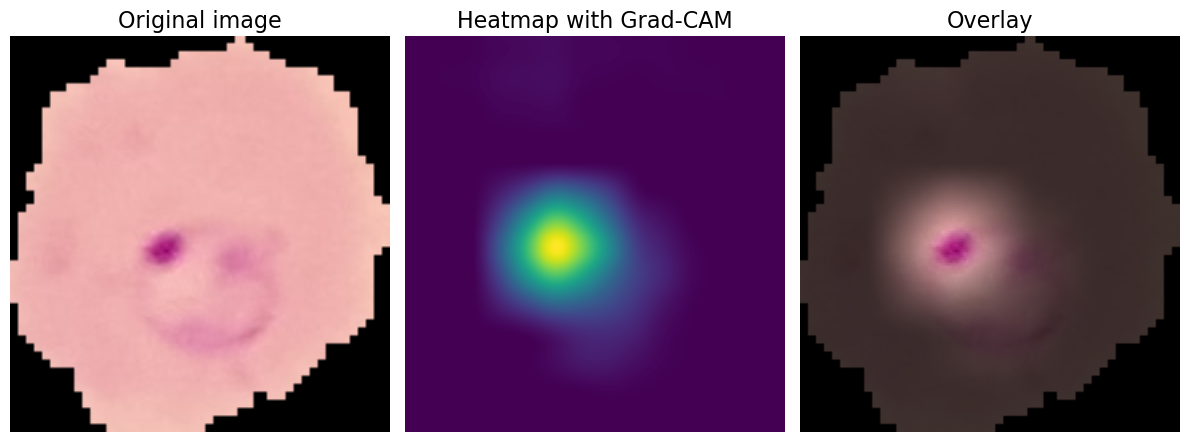

In [ ]:
plot_heatmap(image_hr, heatmap, fig_name= "fig_03_AA.pdf")  ### plot_heatmap(image_hr, heatmap)